## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 4: Smoothing of data, Root finding

<b>Reading:</b> notes below, as well as $\S$[14.9](https://umich.instructure.com/files/5261899/download?download_frd=1) and $\S$[9.0-9.4](https://umich.instructure.com/files/5261898/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes), and $\S$10.2 of [Machine Learning](http://www.astroml.org/).

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt

### Smoothing of data

Often we have data with significant measurement errors.  In case of repeated measurements taken over a period of time (or space), we obtain a <i>time series</i>.  A very useful tool in the analysis of a noisy time series is low-pass filtering, or simply, smoothing of data.  It applies to many situations in signal processing, including for example, improving sound in noise-cancelling headphones or sharpening digital images.

NR $\S$14.9 describes one of the most flexible and efficient filters, the Savitzky-Golay filter.  It works best in case of a measured variable that is varying slowly over at least 10 measurement points.

$$ y_{i,\mathrm{corr}} = \sum_{j=-n}^{n} c_j \, y_{i+j} $$

In the case of all equal $c_j = {1 \over 2n+1}$, it is called <i>moving window averaging</i>.  Although simple, it ignores the second derivative of the data and always reduces the maximum value of a peak.  For example, narrow spectroscopic lines would be artificially reduced and broadened.  The Savitzky-Golay preserves higher moments of the data, by fitting a polynomial of order $n$ around point $x_i$ and using it only to correct the central value $y_i$.  (Incidentally, it means that it can also evaluate the derivative of the data; see NR page 769).  The filter can also be used when the data points are not equally spaced.  It is useful when the signal is recorded with a random delay of the measuring device.

***So Savitzky-Golay preserves derivative (like 2nd deriv), and this is done by changing $c_j$ throughout the sum

Another frequently used filter is Wiener (or, optimal) filter.

Example below shows how the 4th-order Savitzky-Golay filter cleans up the noise, but also reduces narrow peaks described by few data points.  I also add a small positive shift to $x_i$ to mimic recording delay.

In [2]:
xe = np.arange(0, 25, 0.05)
ye = np.exp(-(xe-5.)**2) + np.exp(-(xe-10.)**2/0.5) + \
     np.exp(-(xe-15.)**2/0.1) + np.exp(-(xe-20.)**2/0.05)

np.random.seed(10)
x = xe + 0.2*np.random.random(size=len(xe))
y = ye + np.random.normal(0, 0.2, size=len(ye))

#So we have random noise (np.random.normal could be negative = up and down) 
#& some recording delay (np.random.random always between 0 and 1 = side to side) 

In [3]:
# read in the Savitzky-Golay filter coefficients
# they have a particular wrapping order used in Numerical Recipes
#Broad filter (16 points) and a fourth order polynomial (so super accurate, but need at least 16 pts...would need
#small filter if less points)
c = np.loadtxt("DataFiles/savgol_m4_nlr16.dat", usecols=(0,), unpack=True)
nlr = 16

# smooth data
yf = np.zeros(len(y))
for i in range(nlr,len(y)-nlr):
    yf[i] = y[i]*c[0]
    for j in range(1,nlr+1):
        yf[i] += (y[i+j]+y[i-j])*c[j]
        
        
#Ends are preserved, but middle is packed in particular order by Numer recipes...so basically only need one side
#All linear combinations in middle

Here is the noisy data:

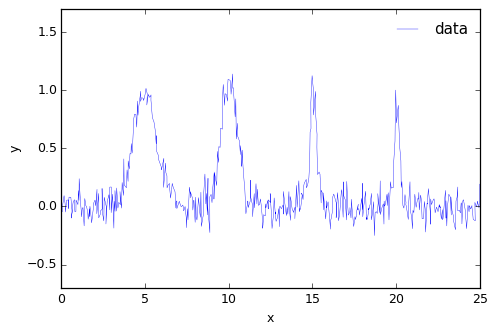

In [31]:
plt.xlim(0, 25)
plt.ylim(-0.7, 1.7)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, 'b-', label='data', lw=0.3)
plt.legend(frameon=False)
plt.show()

Here is the data with overplotted original model:

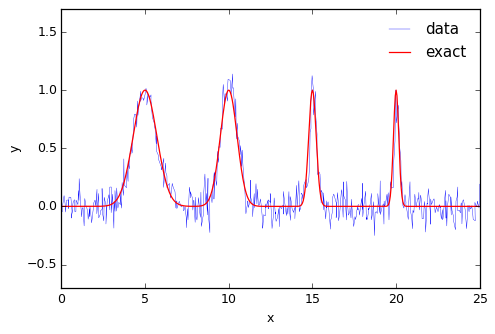

In [32]:
plt.xlim(0, 25)
plt.ylim(-0.7, 1.7)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, 'b-', label='data', lw=0.3)
plt.plot(xe, ye, 'r-', label='exact')
plt.legend(frameon=False)
plt.show()

Here is the smoothed data vs. the original:

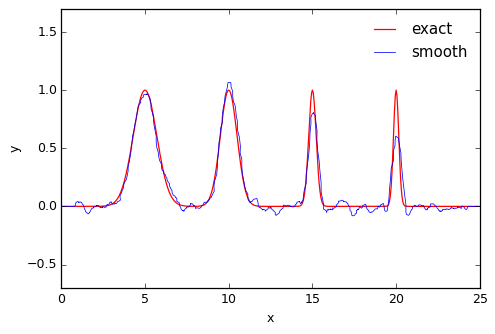

In [33]:
plt.xlim(0, 25)
plt.ylim(-0.7, 1.7)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xe, ye, 'r-', label='exact')
plt.plot(x, yf, 'b-', label='smooth', lw=0.6)
plt.legend(frameon=False)
plt.show()

First peak is perfect, smoothing systematically = smaller and smaller
Using same width of window, if we know what kinds of widths we're recovering, do not pick larger than the line we want. Narrower lines = smaller peak if we pick too big a window. 
Widths are recovered very well, though, even for the narrowest line

You can also use Scipy's implementation [savgol_filter](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) of this filter, where you can choose a different length of the smoothing window. My example above corresponds to $2n+1 = 33$ points.

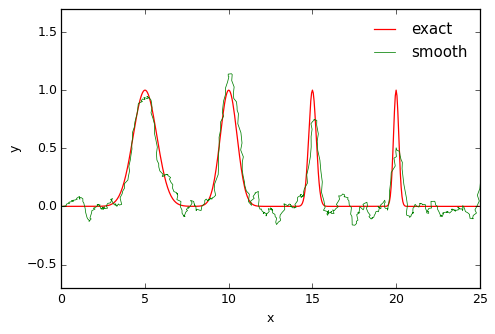

In [8]:
from scipy import signal
ysg = signal.savgol_filter(y, window_length=33, polyorder=4)
#Window = total number of points (so 33 points here)
#Whole scipy method is literally just from interpolation

plt.xlim(0, 25)
plt.ylim(-0.7, 1.7)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xe, ye, 'r-', label='exact')
plt.plot(x, ysg, 'g-', label='smooth', lw=0.6)
plt.legend(frameon=False)
plt.show()

You can output the filter coefficients using the routine [savgol_coeffs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_coeffs.html). Here is an example that replicates my file above:

In [9]:
signal.savgol_coeffs(33, 4)

array([ 0.03685504,  0.002457  , -0.01902195, -0.0297218 , -0.03163493,
       -0.02660614, -0.01633264, -0.00236408,  0.01389751,  0.03119765,
        0.04842946,  0.06463365,  0.07899851,  0.0908599 ,  0.09970128,
        0.10515369,  0.10699576,  0.10515369,  0.09970128,  0.0908599 ,
        0.07899851,  0.06463365,  0.04842946,  0.03119765,  0.01389751,
       -0.00236408, -0.01633264, -0.02660614, -0.03163493, -0.0297218 ,
       -0.01902195,  0.002457  ,  0.03685504])

Can see symmetry (coefficients on outside same, any 6 points away from center are same, etc

Below is an example of using the Wiener filter, with a [SciPy routine](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.wiener.html).  Parameter <b>mysize</b> specifies the filter window.

In [6]:
#Originally 33...but needs a narrower window
yw = signal.wiener(y, mysize=33)
#5 is best for noise
#18 is best for peaks
#16 is most alike

plt.xlim(0, 25)
plt.ylim(-0.7, 1.7)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xe, ye, 'r-', label='exact')
plt.plot(x, yw, 'b-', label='Wiener', lw=0.6)
plt.legend(frameon=False)
plt.show()

NameError: name 'signal' is not defined

<b>Exercise:</b> Find the value of <i>mysize</i> for the Weiner filter that approximates the result of S-G filter, and plot them together.

### Root finding of nonlinear equations

In [4]:
from scipy import special, optimize

One of the most basic numerical tasks you will be facing in your research is solving nonlinear equations, $f(x)=0$, where $f$ is a complicated function.  The problem is <b>much simpler</b> in one dimension (when $x$ is a scalar) than in multiple dimensions (when $\vec{x}$ is a vector).  In one dimension you can bracket the root to lie within an interval, $a < x < b$, and then narrow down the interval until you reach desired precision.  In multiple dimensions it is impossible to do.

The condition for bracketing a root is $f(a) \times f(b) < 0$.  This guarantees that there is at least one root (function changes sign) between $a$ and $b$.  

The simplest method for narrowing down the root value is <i>bisection</i>, where you calculate $f({a+b \over 2})$ and then reassign this midpoint as either new $a$ or new $b$ that satisfy $f(a) f(b) < 0$.

Another method is <i>false-position</i>, where the function $f(x)$ is approximated as linear between points $a$ and $b$
$$ f(x) = f(a) + (f(b)-f(a)) \,\frac{x-a}{b-a} = 0 $$
and the root can be estimated analytically
$$ x = a + (b-a) \,\frac{0-f(a)}{f(b)-f(a)} $$

In practice, there are more sophisticated methods. Scipy's routine [optimize.brentq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) implements one of the most commonly used, Brent's method. It is described in $\S$[9.3](https://umich.instructure.com/files/5261898/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes). It combines the <i>bisection</i> and <i>false-position</i> methods and interpolates the inverse function $x(f)$ at $f=0$.

Let's look at an example of the error function, and its derivative, the Gaussian function:

$$ f(x) = \int_{-x}^{x} \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{t^2}{2}\right) dt = \mathrm{erf}\left(\frac{x}{\sqrt{2}}\right) $$

$$ f'(x) = \frac{2}{\sqrt{2\pi}} \exp\left(-\frac{x^2}{2}\right) $$

The equation we will solve is
$$ \mathrm{erf}\left(\frac{x}{\sqrt{2}}\right) - \mathrm{lev} = 0$$
where $\mathrm{lev}$ are some numbers, whose meaning will become clear in next notebook.

In [8]:
def f(x, lev):
    return special.erf(x/np.sqrt(2.)) - lev

def fprime(x, lev):
    return np.exp(-x**2/2.)*np.sqrt(2./np.pi)

In [9]:
llev = [0.6827, 0.9545, 0.9973]

print [optimize.brentq(f, 0., 4., args=(lev)) for lev in llev]

[1.000021713322963, 2.0000024438997706, 2.999976992703412]


If you can calculate the function's derivative, a typically faster method is due to Newton.  It is implemented in [optimize.newton](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html) and described in $\S$[9.4](https://umich.instructure.com/files/5261898/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes).

When our current estimate of the root is $x$ and $f(x) \neq 0$, we can find a correction $h$ such that
$$ f(x+h) = f(x) + h\, f'(x) + ... = 0 $$
or
$$ h = -\frac{f(x)}{f'(x)} $$
Iterative scheme:
$$ x_{i+1} = x_{i} + h(x_{i}) = x_{i} - \frac{f(x_{i})}{f'(x_{i})} $$

In [10]:
print [optimize.newton(f, 0., args=(lev,), fprime=fprime) for lev in llev]

[1.0000217133229989, 2.0000024438996045, 2.9999769927033841]


In practice, you want to have <i>bisection</i> as backup even to Newton's method, in case the sequence $x_{i}$ goes in the wrong direction for some reason.

<b>Exercise:</b> Write your own routines for Brent's method and Newton's method that replicate the result of the Scipy's routines. Evaluate them for levels = 0.6827, 0.9545, 0.9973. Obtain the root to a user-specified accuracy $\epsilon$. Record the number of iterations needed for each method. Which converges faster?

In [19]:
#Need to check if f(a) * f(b) < 0
#If g(x) = f(x) root, can just say f(x) - g(x) = 0 and again finding roots!
#Giving range a to b, reseting b to (a+b)/2, and checking if sign change

#Point is to shrink domain of values to some delta_x
#Value of function is irrelevant
#So it's when (x - (a+b)/2) < epsilon

#So interpolate function, and then find point in middle
#Check accuracy
#If not good enough...
#Evaluate value of function, and that's new point for interpolation

start = 0.
end = 4.
lev_list = [0.6827, 0.9545, 0.9973]


#def line_interp(f, a, b):
    
    
def brent(f, a, b, lev):
    acc = 1e-5
    mid = (a + b) / 2.
    steps = 0.
    iter_lim = 1000.
    
    f_a = f(a, lev)
    f_b = f(b, lev)
    #f_mid = f(b, lev)
    
    
    #delta = 1.
    if (f_a * f_b) > 0:
        return "Error: Range not bracketed, try new interval"
    
    while np.abs(a - mid) > acc:
        f_mid = f(mid, lev)
        
        
        if (f_a * f_mid) < 0:
            b = mid  
        else:
            a = mid
        
        
        #delta = np.abs(mid - a)
        #mid = (a * f_mid - mid * f_0) / (f_mid - f_0)
        mid = (a + b) / 2.
        steps += 1
        
        
    return a, b, mid#, f(a, lev), f(b, lev), f(mid, lev)
    

#def newton(f, a, b, lev, fprime):

for lev in lev_list:
    print brent(f, 0., 4., lev)
    
    
    

(1.0000152587890625, 1.000030517578125, 1.0000228881835938)
(2.0, 2.0000152587890625, 2.0000076293945312)
(2.999969482421875, 2.9999847412109375, 2.9999771118164062)
